<a href="https://colab.research.google.com/github/snaiws/NLP_project/blob/STS%2Foptimizer/STS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Textual Similarity for Korean



## Import

In [46]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import os
import sys
import re
import pandas as pd
import numpy as np 
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,  RandomSampler, SequentialSampler, random_split
from torch.nn.utils import clip_grad_norm_

from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup


In [48]:
#reset gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [49]:
# seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


### Given data

In [50]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
cd /content/drive/MyDrive/NLP_project

/content/drive/MyDrive/NLP_project


In [52]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")
_DATA_DIR = os.path.join(_CUR_DIR, "data/klue-sts-v1.1")
print(f"My data directory : {_DATA_DIR}")

My current directory : /content/drive/MyDrive/NLP_project
My data directory : /content/drive/MyDrive/NLP_project/data/klue-sts-v1.1


In [53]:
# 파일 내 json 불러오기
df_train0 = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_train.json')
df_test0 = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_dev.json')

In [54]:
# shape
df_train0.shape, df_test0.shape

((11668, 6), (519, 6))

### Collected data

### Analysis

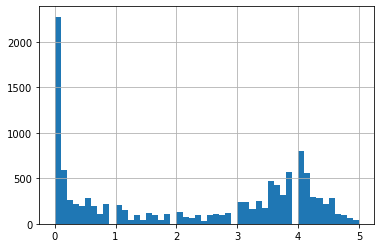

In [55]:
df_train0['labels'].map(lambda x: x['real-label']).hist(bins=50)

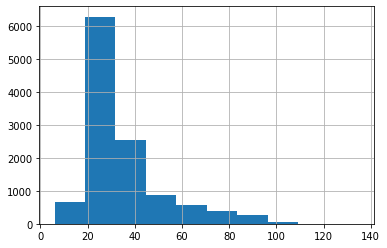

In [56]:
df_train0['sentence1'].map(lambda x: len(x)).hist()

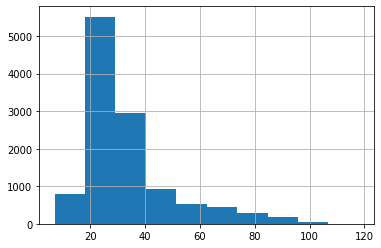

In [57]:
df_train0['sentence2'].map(lambda x: len(x)).hist()

In [58]:
df_train0[df_train0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations
1514,klue-sts-v1_train_01514,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
1661,klue-sts-v1_train_01661,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
1715,klue-sts-v1_train_01715,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
3872,klue-sts-v1_train_03872,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."
5139,klue-sts-v1_train_05139,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
5292,klue-sts-v1_train_05292,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
7045,klue-sts-v1_train_07045,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10908,klue-sts-v1_train_10908,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10939,klue-sts-v1_train_10939,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
11112,klue-sts-v1_train_11112,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."


In [59]:
df_test0[df_test0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations


In [60]:
pd.concat([df_train0.drop_duplicates(['sentence1','sentence2']),df_test0]).duplicated(['sentence1','sentence2']).sum()

0

In [61]:
df_train0.isna().sum().sum()+df_test0.isna().sum().sum()

0

## Data preprocess

In [62]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer

### Preprocess

In [124]:
class Preprocess:
    def __init__(self,train,test):
        self.train=train
        self.test=test

    def check_st(self, text):
      text = re.sub('a-zA-Z一-龥㐀-䶵豈-龎[-=+,#/\?:^$.@*\"※~&%ㆍ·!』\\‘〈〉|\(\)\[\]\<\>`\'…》《]','', text)
      return text
    
    def BERT_baseline(self):
        train = self.train.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
        sentence = train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = train['labels'].map(lambda x: int(x['real-label']))
        train = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence','label']
        sentence = self.test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.test['labels'].map(lambda x: int(x['real-label']))
        test = pd.concat([sentence,label],axis=1)
        test.columns = ['sentence','label']
        return train, test

    def BERT_round(self):
        train = self.train.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
        sentence = train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = train['labels'].map(lambda x: round(x['real-label']))
        train = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence','label']
        sentence = self.test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.test['labels'].map(lambda x: round(x['real-label']))
        test = pd.concat([sentence,label],axis=1)
        test.columns = ['sentence','label']
        return train, test

    def BERT_Siamese(self):
        train = self.train.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
        sentence = train[['sentence1','sentence2']]
        label = train['labels'].map(lambda x: int(x['real-label']))
        train = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence1','sentence2','label']
        sentence = train[['sentence1','sentence2']]
        label = self.test['labels'].map(lambda x: int(x['real-label']))
        test = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence1','sentence2','label']
        return train, test

In [125]:
pp=Preprocess(df_train0,df_test0)

In [126]:
df_train, df_test = pp.BERT_baseline()

In [127]:
df_train.head()

,sentence,label
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. [SEP] 숙박시설의 위...,3
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. ...,0
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. [SEP] ...,0
3,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...",0
4,"호스트의 답장이 늦으나, 개선될 것으로 보입니다. [SEP] 호스트 응답이 늦었지만...",4


In [67]:
df_train['label'].value_counts()

0    4350
3    2852
4    2698
1     906
2     810
5      45
Name: label, dtype: int64

### Augmentation

### Dataset

In [68]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [69]:
train_dataset = CustomDataset(df_train.sentence.to_list(), df_train.label.to_list())
test_dataset = CustomDataset(df_test.sentence.to_list(), df_test.label.to_list())

### Split Data

In [70]:
n_sample = df_train.shape[0] # train 전체 길이
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

In [71]:
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Valid Dataset len: {len(valid_dataset)}")
print(f"Test Dataset len: {len(test_dataset)}")

Train Dataset len: 10494
Valid Dataset len: 1167
Test Dataset len: 519


## Model

### Custom Model

In [72]:
!git clone https://github.com/snaiws/NLP_project

fatal: destination path 'NLP_project' already exists and is not an empty directory.


In [73]:
from NLP_project.CustomModels.BERT_baseline import Bert_baseline

### ARGUMENT

In [74]:
# argument setting
train_batch_size = 58
eval_batch_size = 64
epochs=25
patience=2

loss_fct = nn.CrossEntropyLoss()
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
customModel = Bert_baseline(hidden_size=768, n_label=6)
customOptimizer = AdamW(
    customModel.parameters(), # update 대상 파라미터를 입력
    lr=4.335281794951567e-06,
    eps=1e-8
)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprec

### Data Loader

In [75]:
# Custom collate_fn 
def custom_collate_fn(batch):
    """
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input_list,
        add_special_tokens=True,
        padding="longest", # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [76]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    sampler = RandomSampler(train_dataset),
    collate_fn = custom_collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = eval_batch_size,
    sampler = SequentialSampler(valid_dataset),
    collate_fn = custom_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = eval_batch_size,
    sampler = SequentialSampler(test_dataset),
    collate_fn = custom_collate_fn
)
print(f"Train dataloader # steps: {len(train_dataloader)}")
print(f"Valid dataloader # steps: {len(valid_dataloader)}")
print(f"Test dataloader # steps: {len(test_dataloader)}")

Train dataloader # steps: 181
Valid dataloader # steps: 19
Test dataloader # steps: 9


### Initializer

In [77]:
def initializer(model, optimizer, train_dataloader, epochs=2):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

### Early stopping

In [78]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.path.abspath(os.curdir)

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, epoch, loss):
        file_name = f'{self.path}/model.ckpt.best'
        
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss' : loss
            }, 
            file_name
        )
      
        print(f"Saving epoch {epoch} checkpoint at {file_name}")

### Validate

In [79]:
def validate(model, valid_dataloader):
   
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fct(logits, batch_label)
        total_loss += loss.item()
        
        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc
    

## Train

In [80]:
def train_model(model, train_dataloader, valid_dataloader=None, epochs=1):
    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    
    # train_dataloaer 학습을 epochs만큼 반복
    for epoch in range(1, epochs + 1):
        print(f"*****Epoch {epoch} Train Start*****")
        
        # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
        total_loss, batch_loss, batch_count = 0,0,0
    
        # model을 train 모드로 설정 & device 할당
        model.train()
        model.to(device)
        
        # data iterator를 돌면서 하나씩 학습
        for step, batch in enumerate(train_dataloader):
            batch_count+=1
            
            # tensor 연산 전, 각 tensor에 device 할당
            batch = tuple(item.to(device) for item in batch)
        
            batch_input, batch_label = batch
        
            # batch마다 모델이 갖고 있는 기존 gradient를 초기화
            model.zero_grad()
        
            # forward
            logits = model(**batch_input)
        
            # loss
            loss = loss_fct(logits, batch_label)
            batch_loss += loss.item()
            total_loss += loss.item()
        
            # backward -> 파라미터의 미분(gradient)를 자동으로 계산
            loss.backward()
            
            # gradient clipping 적용 
            clip_grad_norm_(model.parameters(), 1.0)
            
            # optimizer & scheduler 업데이트
            optimizer.step()
            scheduler.step()

            # 배치 10개씩 처리할 때마다 평균 loss와 lr를 출력
            if (step % 10 == 0 and step != 0):
                learning_rate = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                # reset 
                batch_loss, batch_count = 0,0
        
        print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
        print(f"*****Epoch {epoch} Train Finish*****\n")
        
        if valid_dataloader is not None:
            print(f"*****Epoch {epoch} Valid Start*****")
            valid_loss, valid_acc = validate(model, valid_dataloader)
            print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
            print(f"*****Epoch {epoch} Valid Finish*****\n")

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        #  만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model, optimizer, scheduler, epoch)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
            
    print("Train Completed. End Program.")

In [81]:
model, optimizer, scheduler = initializer(customModel, customOptimizer, train_dataloader, epochs)
train_model(model, train_dataloader, valid_dataloader, epochs)

Total train steps with 25 epochs: 4525
*****Epoch 1 Train Start*****
Epoch: 1, Step : 10, LR : 4.3247429883782035e-06, Avg Loss : 1.8099
Epoch: 1, Step : 20, LR : 4.315162255129692e-06, Avg Loss : 1.7474
Epoch: 1, Step : 30, LR : 4.30558152188118e-06, Avg Loss : 1.7077
Epoch: 1, Step : 40, LR : 4.296000788632668e-06, Avg Loss : 1.6527
Epoch: 1, Step : 50, LR : 4.286420055384157e-06, Avg Loss : 1.5964
Epoch: 1, Step : 60, LR : 4.276839322135645e-06, Avg Loss : 1.5426
Epoch: 1, Step : 70, LR : 4.267258588887133e-06, Avg Loss : 1.4797
Epoch: 1, Step : 80, LR : 4.257677855638622e-06, Avg Loss : 1.4529
Epoch: 1, Step : 90, LR : 4.24809712239011e-06, Avg Loss : 1.3227
Epoch: 1, Step : 100, LR : 4.238516389141598e-06, Avg Loss : 1.3617
Epoch: 1, Step : 110, LR : 4.228935655893086e-06, Avg Loss : 1.3628
Epoch: 1, Step : 120, LR : 4.219354922644575e-06, Avg Loss : 1.2882
Epoch: 1, Step : 130, LR : 4.209774189396063e-06, Avg Loss : 1.2785
Epoch: 1, Step : 140, LR : 4.200193456147551e-06, Avg Los

## Evaluation

### Load checkpoint

In [82]:
best_epoch = input()
checkpoint = torch.load(f'./model_ckpt_{best_epoch}')

7


In [83]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [84]:
epochs=1
model, optimizer, scheduler = initializer(customModel, customOptimizer, train_dataloader, epochs)

Total train steps with 1 epochs: 181


In [85]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### predict and evaluate

In [36]:
def predict(model, test_dataloader):
    """
    test_dataloader의 label별 확률값과 실제 label 값을 반환
    """

    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        print(f"{step}/{len(test_dataloader)}")
        
        batch_input, batch_label = batch
        
        batch_input = batch_input.to(device)
        
        with torch.no_grad():
            logits = model(**batch_input)
            all_logits.append(logits)
        all_labels.extend(batch_label)

    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = np.array(all_labels)

    return probs, all_labels


In [86]:
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [87]:
pred = list(map(np.argmax,probs))

In [37]:
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import pearsonr
def evaluate(pred, test):
    pred_binary = list(map(lambda x: 1 if x>=3 else 0, pred))
    test_binary_label = list(map(lambda x: 1 if x>=3 else 0, test))
    print(f'acc : {accuracy_score(test_binary_label, pred_binary)}')
    print(f'f1 : {f1_score(test_binary_label, pred_binary)}')
    print(f'pearson : {pearsonr(test, pred)}')
    return f1_score(test_binary_label, pred_binary)
    

In [88]:
evaluate(pred, labels)

acc : 0.7379576107899807
f1 : 0.5903614457831325
pearson : (0.6774412434544649, 5.7523813412947176e-71)


0.5903614457831325

### Save outputs

In [ ]:
output = pd.DataFrame(labels,columns=['pred_real_label'])
filename = input()
output.to_csv(f'{filename}.csv')

first_pred


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

## Load model weights

In [ ]:
model = Bert_baseline(hidden_size=768, n_label=6)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [ ]:
pred = list(map(np.argmax,probs))
evaluate(pred, labels)

acc : 0.7533718689788054
f1 : 0.7697841726618705
pearson : (0.7789983354145806, 7.071859924703616e-107)


## Hyperparameter tuning

In [38]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import optuna

In [40]:
def optuna_train(model, optimizer):
    model.train()
    model.to(device)
    for step, batch in enumerate(train_dataloader):
        batch = tuple(item.to(device) for item in batch)
        batch_input, batch_label = batch
        model.zero_grad()
        logits = model(**batch_input)
        loss = loss_fct(logits, batch_label)
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

In [44]:
def objective(trial):  # `trial` is an object passed by Optuna.
    train_batch_size = trial.suggest_int("train_batch_size",24,64)
    lr = trial.suggest_float("lr",1e-6,1e-3,log=True)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size = train_batch_size,
        sampler = RandomSampler(train_dataset),
        collate_fn = custom_collate_fn
    )


    model = Bert_baseline(hidden_size=768, n_label=6)
    optimizer = torch.optim.Adam(
        model.parameters(), lr = lr
        )
    val_list = []
    for epoch in range(4):
        optuna_train(model,optimizer)
        valid_loss, valid_acc = validate(model, valid_dataloader)
        print(f'val_los : {valid_loss}')
        trial.report(valid_loss, step = epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        val_list.append(valid_loss)
    return min(val_list)

In [45]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study.optimize(objective, n_trials=30)

[I 2022-05-30 07:24:53,516] A new study created in memory with name: no-name-d305b776-0710-457d-b411-96195e76df44
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 1.4368336514422768
val_los : 1.4357173693807501
val_los : 1.4345683612321551


[I 2022-05-30 07:35:50,698] Trial 0 finished with value: 1.4345683612321551 and parameters: {'train_batch_size': 39, 'lr': 0.0007114476009343421}. Best is trial 0 with value: 1.4345683612321551.


val_los : 1.4349377280787419


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 0.9282781450371993
val_los : 0.9060067063883731
val_los : 0.9260139308477703


[I 2022-05-30 07:46:50,150] Trial 1 finished with value: 0.9060067063883731 and parameters: {'train_batch_size': 54, 'lr': 6.251373574521755e-05}. Best is trial 1 with value: 0.9060067063883731.


val_los : 0.9479707071655675


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 1.121367495310934
val_los : 0.9017338344925329
val_los : 0.8365192821151332


[I 2022-05-30 07:57:50,584] Trial 2 finished with value: 0.8254518006977282 and parameters: {'train_batch_size': 30, 'lr': 2.9375384576328313e-06}. Best is trial 2 with value: 0.8254518006977282.


val_los : 0.8254518006977282


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 1.6553459669414319
val_los : 1.6069970695595992
val_los : 1.5698014372273494


[I 2022-05-30 08:08:16,231] Trial 3 pruned. 


val_los : 1.541549889664901


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 1.1715391372379504


[I 2022-05-30 08:13:46,041] Trial 4 pruned. 


val_los : 1.0899092743271275


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 1.4338961965159367
val_los : 1.442325748895344
val_los : 1.436846846028378


[I 2022-05-30 08:24:45,220] Trial 5 pruned. 


val_los : 1.4334190707457692


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_los : 0.7546168408895794
val_los : 0.6903386617961683
val_los : 0.6775528286632738


[I 2022-05-30 08:35:45,936] Trial 6 finished with value: 0.6775528286632738 and parameters: {'train_batch_size': 58, 'lr': 4.335281794951567e-06}. Best is trial 6 with value: 0.6775528286632738.


val_los : 0.6776950265231886


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: ignored

In [53]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

ValueError: ignored